In [ ]:
!pip install iglovikov_helper_functions
!pip install cloths_segmentation  > /dev/null
!wget --no-check-certificate https://github.com/Odilbek99/cv-project-task/archive/master.zip
!unzip master.zip

In [3]:
from pylab import imshow
import pylab
import os
import random
from tqdm import tqdm
import tqdm.notebook as tq
import numpy as np
import cv2
import torch
import albumentations as albu
import matplotlib.pyplot as plt

from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image

from cloths_segmentation.pre_trained_models import create_model

%matplotlib inline

In [ ]:
model = create_model("Unet_2020-10-30")

In [5]:
model.eval();

In [61]:
def get_files_list(folder_path):
    image_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg"):
                image_files.append(os.path.join(root, file))
    return image_files

def select_random_images(images_list, n_images):
    random_images_list = random.sample(images_list, n_images)
    return random_images_list

def showInRow(list_of_images):
  plt.figure(figsize=(18, 18))
  n = len(list_of_images)
  for img in range(n):
    image = load_rgb(list_of_images[img])
    plt.subplot(1, n, img+1)
    plt.title(img+1)
    plt.imshow(image)

def get_masks(original_image_list):
  for img in tq.tqdm(original_image_list):
    image = load_rgb(img)
    transform = albu.Compose([albu.Normalize(p=1)], p=1)
    padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)
    x = transform(image=padded_image)["image"]
    x = torch.unsqueeze(tensor_from_rgb_image(x), 0)
    with torch.no_grad():
      prediction = model(x)[0][0]

    mask = (prediction < 0).cpu().numpy().astype(np.uint8)
    mask = unpad(mask, pads)

    if not os.path.exists('task2_data/masks'):
      os.makedirs('task2_data/masks')
    if not os.path.exists('task2_data/Original'):
      os.makedirs('task2_data/Original')

    orig_img = cv2.imread(img)
    mask_wb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255

    mask_name = img.split('/')[-1].split('.')[0] + '_mask.jpg'
    orig_img_name = img.split('/')[-1].split('.')[0] + '.jpg'

    cv2.imwrite(f'task2_data/masks/{mask_name}', mask_wb)    
    cv2.imwrite(f'task2_data/Original/{orig_img_name}', orig_img)

  return

def preprocess(cloth, cloth_mask):
  image = load_rgb(cloth)
  mask = load_rgb(cloth_mask)
  mask_re = (cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) * 255).astype(np.uint8)
  
  dst = cv2.addWeighted(image, 0.5, (cv2.cvtColor(mask_re, cv2.COLOR_GRAY2RGB) * (0, 0, 255)).astype(np.uint8), 0.5,0)

  if not os.path.exists('task2_data/Blue Color Background'):
      os.makedirs('task2_data/Blue Color Background') 

  image_name = cloth.split('/')[-1].split('.')[0] + '_blue_bg.jpg'
  cv2.imwrite(f'task2_data/Blue Color Background/{image_name}',cv2.cvtColor(dst, cv2.COLOR_RGB2BGR))
  return 

**Step 1:** Getting list of Not Weared Images

In [46]:
not_weared_image_list = get_files_list('/content/cv-project-task-master/Scraper/data/Images/Not Weared')
not_weared_image_list[:5]

['/content/cv-project-task-master/Scraper/data/Images/Not Weared/Spa Terry Full-Zip HoodieNot-Weared.jpg',
 '/content/cv-project-task-master/Scraper/data/Images/Not Weared/Fleece Logo Rugby SweatshirtNot-Weared.jpg',
 '/content/cv-project-task-master/Scraper/data/Images/Not Weared/Striped Fleece HoodieNot-Weared.jpg',
 '/content/cv-project-task-master/Scraper/data/Images/Not Weared/Double-Knit PulloverNot-Weared.jpg',
 '/content/cv-project-task-master/Scraper/data/Images/Not Weared/Hybrid Bomber JacketNot-Weared.jpg']

**Step 2:** Selecting Random Images from "**not_weared_image_list**" to visualize them  

In [47]:
random_imgs = select_random_images(not_weared_image_list, 5) # Selects 5 random images, you can use any number 
random_imgs

['/content/cv-project-task-master/Scraper/data/Images/Not Weared/Logo Fleece HoodieNot-Weared.jpg',
 '/content/cv-project-task-master/Scraper/data/Images/Not Weared/Logo Waffle-Knit T-ShirtNot-Weared.jpg',
 '/content/cv-project-task-master/Scraper/data/Images/Not Weared/Double-Knit PulloverNot-Weared.jpg',
 '/content/cv-project-task-master/Scraper/data/Images/Not Weared/Fleece SweatshirtNot-Weared.jpg',
 '/content/cv-project-task-master/Scraper/data/Images/Not Weared/Hybrid Bomber JacketNot-Weared.jpg']

**Step 3:** Visualizing Random Images that we got from "**not_weared_image_list**"

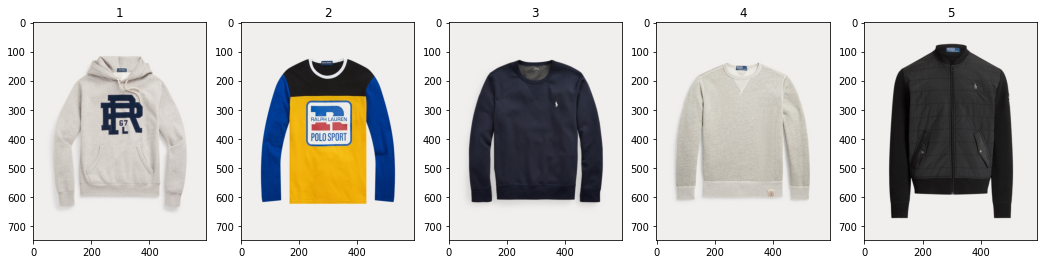

In [62]:
showInRow(random_imgs)

**Step 4:** Getting masks of images above that we got randomly and download them

In [49]:
get_masks(random_imgs)

  0%|          | 0/5 [00:00<?, ?it/s]

Now we have saved original and mask images to the folder task2_data we can retrieve this data names using "**get_files_list**" method. 

**Step 5:** Getting list of original and masks names to use them in final function



In [50]:
mask_path = sorted(get_files_list('/content/task2_data/masks/'))
image_path = sorted(get_files_list('/content/task2_data/Original/'))
print('Mask:',mask_path[0])
print('Original Image: ',image_path[0])

Mask: /content/task2_data/masks/Double-Knit PulloverNot-Weared_mask.jpg
Original Image:  /content/task2_data/Original/Double-Knit PulloverNot-Weared.jpg


**Last Step 6:** Now here we choose or we can also iterate through images in mask and original image list. Our function saves the original image with blue color background image. It is possible to iterate for each random taken image. but for simplicity I use only one image as an example.

> **Path to the folder is**: task2_data/Blue Color Background

In [51]:
for img in tq.tqdm(range(len(image_path))):
  preprocess(image_path[img], mask_path[img])

  0%|          | 0/5 [00:00<?, ?it/s]

## Visualization

In [67]:
blue_bg = sorted(get_files_list('/content/task2_data/Blue Color Background'))
org = sorted(get_files_list('/content/task2_data/Original'))
mask = sorted(get_files_list('/content/task2_data/masks'))

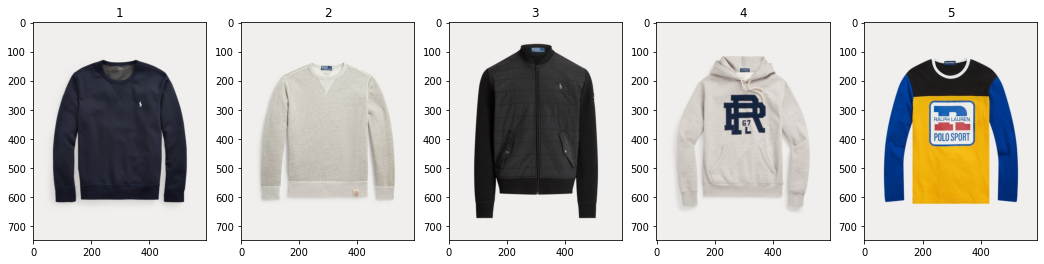

In [68]:
showInRow(org)

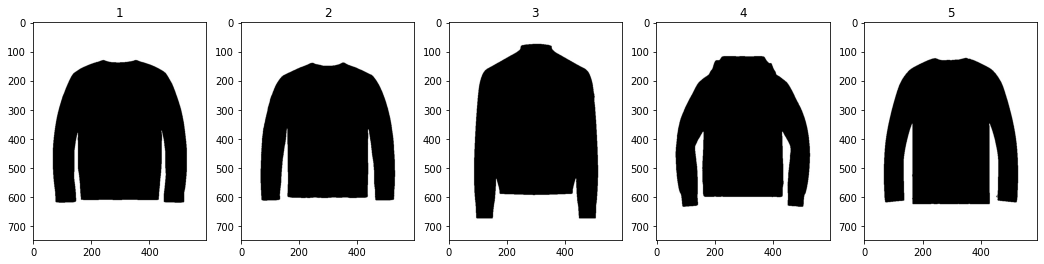

In [69]:
showInRow(mask)

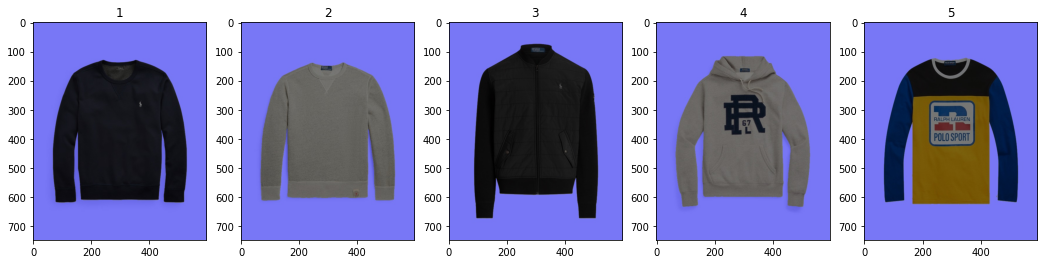

In [70]:
showInRow(blue_bg)

## Download Data

In [ ]:
from google.colab import files
!zip -r /content/file.zip /content/task2_data/
files.download("/content/file.zip")